# Home Equity Loan Default Prediction (CEN 352)

**Kaggle Username (Name):** Endri Baku

This notebook is submitted as part of the CEN 352 midterm assignment.
The goal is to predict whether a home equity loan applicant will default
using machine learning and deep learning techniques.


## Problem Description

This project focuses on predicting loan default risk using a real-world
home equity loan dataset containing 5,960 records.

The target variable **BAD** is binary:
- `1` → Applicant defaulted or became seriously delinquent
- `0` → Applicant successfully paid the loan

Approximately **20%** of the applicants defaulted, making this an
imbalanced classification problem. Because of this imbalance,
metrics such as **Precision, Recall, and F1-score** are more appropriate
than accuracy.


## Dataset Overview

The dataset contains **12 input features** describing loan, property,
employment, and credit history characteristics.

### Feature Summary
- **Numeric features**: LOAN, MORTDUE, VALUE, YOJ, DEROG, DELINQ,
  CLAGE, NINQ, CLNO, DEBTINC
- **Categorical features**: REASON, JOB
- **Target variable**: BAD

The data is already split into training and test sets.


In [231]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use("seaborn-v0_8")
sns.set_context("notebook")



In [232]:
train_df = pd.read_csv("cen-352-swe-2026-home-equity-loan/train2023.csv")
test_df  = pd.read_csv("cen-352-swe-2026-home-equity-loan/test2023.csv")

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)


Training data shape: (4768, 14)
Test data shape: (1192, 13)


In [233]:
train_df.head()
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4768 entries, 0 to 4767
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    4768 non-null   int64  
 1   DEBTINC  3741 non-null   float64
 2   LOAN     4768 non-null   int64  
 3   MORTDUE  4365 non-null   float64
 4   VALUE    4680 non-null   float64
 5   REASON   4568 non-null   object 
 6   JOB      4550 non-null   object 
 7   YOJ      4357 non-null   float64
 8   DEROG    4193 non-null   float64
 9   DELINQ   4300 non-null   float64
 10  CLAGE    4531 non-null   float64
 11  NINQ     4352 non-null   float64
 12  CLNO     4592 non-null   float64
 13  BAD      4768 non-null   int64  
dtypes: float64(9), int64(3), object(2)
memory usage: 521.6+ KB


,index,DEBTINC,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,BAD
count,4768.000000,3741.000000,4768.000000,4365.000000,4680.000000,4357.000000,4193.000000,4300.000000,4531.000000,4352.000000,4592.000000,4768.000000
mean,2383.500000,33.864152,18595.050336,74254.645874,102884.609090,8.868442,0.254472,0.458140,179.442286,1.181756,21.391551,0.200503
std,1376.547372,8.141801,11143.678091,44203.791750,58579.950268,7.535995,0.867605,1.124849,85.609878,1.733127,10.119090,0.400419
min,0.000000,0.720295,1300.000000,2063.000000,8800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1191.750000,29.220351,11100.000000,46775.000000,66527.000000,3.000000,0.000000,0.000000,115.543501,0.000000,15.000000,0.000000
50%,2383.500000,34.871855,16300.000000,65889.000000,89789.000000,7.000000,0.000000,0.000000,172.799301,1.000000,20.000000,0.000000
75%,3575.250000,39.077814,23400.000000,92613.000000,121733.500000,13.000000,0.000000,0.000000,230.711163,2.000000,26.000000,0.000000
max,4767.000000,144.189001,89900.000000,399412.000000,855909.000000,41.000000,10.000000,13.000000,1168.233561,17.000000,71.000000,1.000000


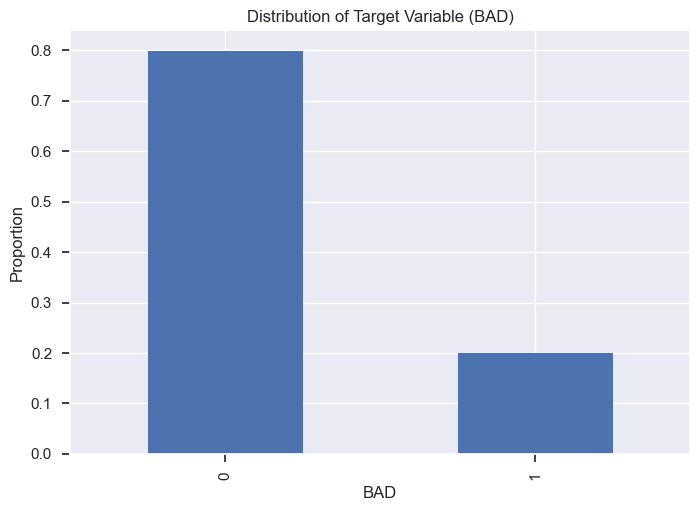

0    0.799497
1    0.200503
Name: BAD, dtype: float64

In [234]:
target_dist = train_df["BAD"].value_counts(normalize=True)

target_dist.plot(
    kind="bar",
    title="Distribution of Target Variable (BAD)",
    xlabel="BAD",
    ylabel="Proportion"
)
plt.show()

target_dist


The target distribution confirms that loan defaults represent
approximately 20% of the dataset. This imbalance motivates the use of
Precision–Recall–based evaluation and careful decision threshold selection.


## Data Quality and Missing Values

Several features in the dataset contain missing values, particularly
credit-related and financial variables. Since missingness may reflect
real-world data collection limitations, careful imputation is required
to avoid information leakage or bias.


### Missing Values Summary


In [235]:
train_df.isnull().sum().sort_values(ascending=False)


DEBTINC    1027
DEROG       575
DELINQ      468
NINQ        416
YOJ         411
MORTDUE     403
CLAGE       237
JOB         218
REASON      200
CLNO        176
VALUE        88
index         0
LOAN          0
BAD           0
dtype: int64

In [236]:
# Separate features by type
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
numeric_cols = numeric_cols.drop("BAD")

categorical_cols = train_df.select_dtypes(include=["object"]).columns

# Median imputation for numeric features
for col in numeric_cols:
    median_value = train_df[col].median()
    train_df[col].fillna(median_value, inplace=True)
    test_df[col].fillna(median_value, inplace=True)

# Mode imputation for categorical features
for col in categorical_cols:
    mode_value = train_df[col].mode()[0]
    train_df[col].fillna(mode_value, inplace=True)
    test_df[col].fillna(mode_value, inplace=True)


In [237]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()


(0, 0)

## Exploratory Data Analysis

The goal of this exploratory analysis is to understand the relationship
between key applicant characteristics and loan default behavior.
Only a limited number of informative visualizations are included to
avoid redundancy and overfitting to visual patterns.


The dataset is imbalanced, with approximately 20% of loans resulting
in default. This imbalance is considered throughout the modeling process.


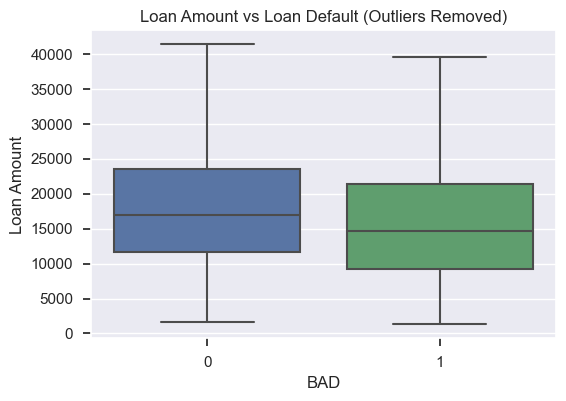

In [238]:
plt.figure(figsize=(6,4))
sns.boxplot(
    x="BAD",
    y="LOAN",
    data=train_df,
    showfliers=False
)
plt.title("Loan Amount vs Loan Default (Outliers Removed)")
plt.xlabel("BAD")
plt.ylabel("Loan Amount")
plt.show()



The distribution of loan amounts shows substantial overlap between
defaulted and non-defaulted loans. While non-defaulted applicants
tend to have slightly higher median loan amounts, loan size alone
does not appear to be a strong predictor of default.

This suggests that loan amount is more informative when combined
with other credit-related features rather than in isolation.


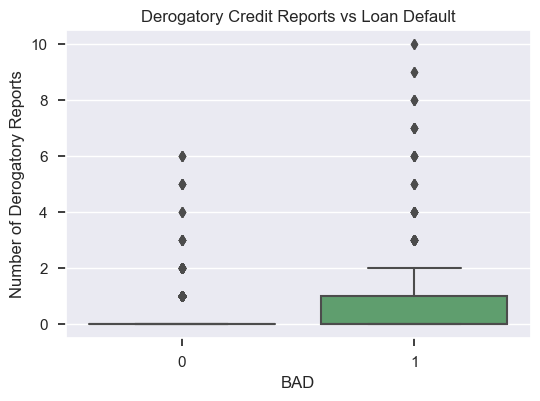

In [239]:
plt.figure(figsize=(6,4))
sns.boxplot(x="BAD", y="DEROG", data=train_df)
plt.title("Derogatory Credit Reports vs Loan Default")
plt.xlabel("BAD")
plt.ylabel("Number of Derogatory Reports")
plt.show()


Applicants who default tend to have a higher number of major derogatory
credit reports. This feature shows clear separation between the two classes,
indicating strong predictive power for loan default.


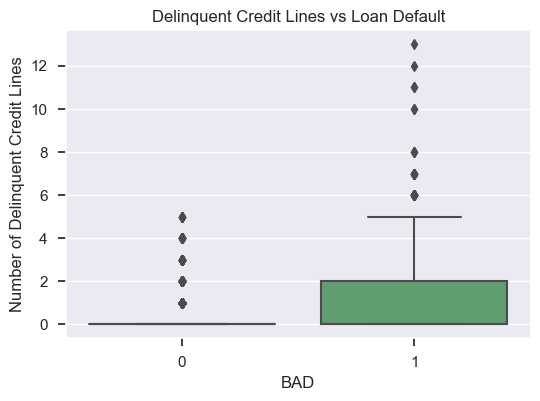

In [240]:
plt.figure(figsize=(6,4))
sns.boxplot(x="BAD", y="DELINQ", data=train_df)
plt.title("Delinquent Credit Lines vs Loan Default")
plt.xlabel("BAD")
plt.ylabel("Number of Delinquent Credit Lines")
plt.show()


The number of delinquent credit lines is noticeably higher among
defaulted loans. This confirms that recent repayment behavior
is a strong indicator of default risk.


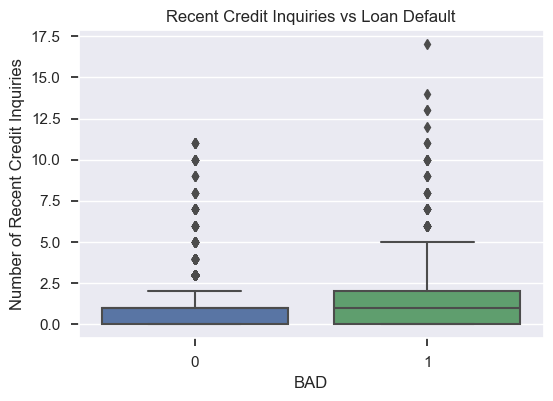

In [241]:
plt.figure(figsize=(6,4))
sns.boxplot(x="BAD", y="NINQ", data=train_df)
plt.title("Recent Credit Inquiries vs Loan Default")
plt.xlabel("BAD")
plt.ylabel("Number of Recent Credit Inquiries")
plt.show()


Applicants with a higher number of recent credit inquiries are more
likely to default, suggesting increased financial stress or credit-seeking
behavior prior to loan application.


### Credit Risk Feature Insights

Credit history variables such as **DEROG**, **DELINQ**, and **NINQ**
show strong association with loan default. These features are expected
to play a major role in both traditional machine learning models and
the deep learning model developed later in this study.


## Feature Encoding and Scaling

Machine learning and deep learning models require numerical input.
Therefore, categorical variables must be encoded, and numeric variables
must be scaled to ensure stable and efficient model training.

All preprocessing steps are fitted on the training data only to prevent
data leakage.


In [242]:
# Separate features and target (DROP index from features)
X_train = train_df.drop(columns=["BAD", "index"])
y_train = train_df["BAD"]

X_test = test_df.drop(columns=["index"])



In [243]:
X_train = pd.get_dummies(X_train, columns=["REASON", "JOB"], drop_first=True)
X_test  = pd.get_dummies(X_test, columns=["REASON", "JOB"], drop_first=True)


In [244]:
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)


In [245]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [246]:
print("Training features shape:", X_train_scaled.shape)
print("Test features shape:", X_test_scaled.shape)
print("Target shape:", y_train.shape)


Training features shape: (4768, 16)
Test features shape: (1192, 16)
Target shape: (4768,)


Categorical variables were encoded using one-hot encoding to preserve
category information without imposing artificial order. Numeric features
were standardized to improve neural network training stability.

All transformations were learned exclusively from the training set to
avoid data leakage.


## Baseline Model

Before applying deep learning, a baseline model is trained to establish
a reference level of performance. Logistic Regression is chosen due to
its simplicity, interpretability, and common use in credit risk modeling.


In [247]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)


In [248]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_tr, y_tr)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [249]:
y_val_pred = log_reg.predict(X_val)
y_val_proba = log_reg.predict_proba(X_val)[:, 1]


In [250]:
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.90      0.77      0.83       763
           1       0.41      0.65      0.50       191

    accuracy                           0.74       954
   macro avg       0.65      0.71      0.66       954
weighted avg       0.80      0.74      0.76       954



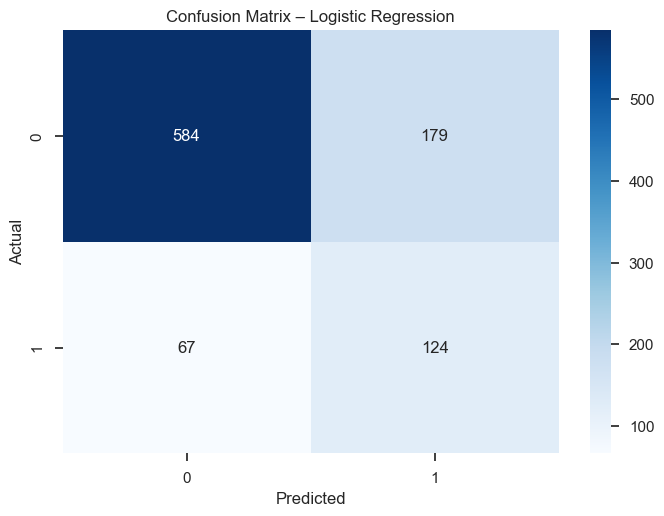

In [251]:
sns.heatmap(
    confusion_matrix(y_val, y_val_pred),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [252]:
f1 = f1_score(y_val, y_val_pred)
print("Validation F1-score:", f1)


Validation F1-score: 0.5020242914979757


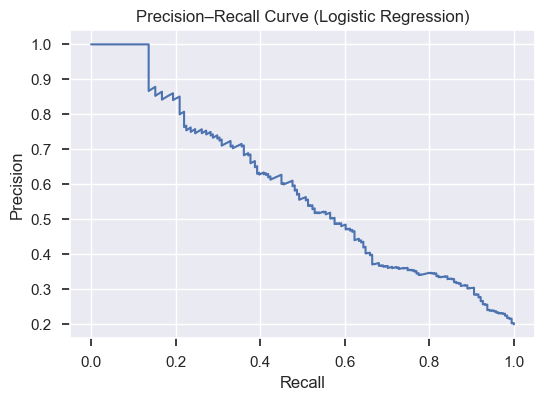

In [253]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.show()


### Baseline Model Summary

The Logistic Regression model provides a reasonable baseline performance
while highlighting the challenges of class imbalance in loan default
prediction. Although interpretable, the linear nature of this model
limits its ability to capture complex interactions between credit
and financial features.

This motivates the use of a deep learning model in the next step.


## Deep Learning Model

While the baseline Logistic Regression model provides a useful reference,
it is limited to linear decision boundaries. Credit risk prediction often
depends on nonlinear interactions between financial burden, credit history,
and employment characteristics.

An Artificial Neural Network (ANN) is therefore used to capture these
complex relationships.


### Model Architecture

The neural network consists of:
- An input layer matching the number of preprocessed features
- Two hidden layers with ReLU activation
- Dropout regularization to reduce overfitting
- A sigmoid output layer for binary classification


In [254]:
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.4),

    Dense(64, activation="relu"),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               2176      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10497 (41.00 KB)
Trainable params: 10497 (41.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [255]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=12,
    restore_best_weights=True
)

In [256]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

class_weight_dict


{0: 0.6253934942287513, 1: 2.493723849372385}

In [257]:
history = model.fit(
    X_tr,
    y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
120/120 [==============================] - 0s 1ms/step - loss: 0.6104 - accuracy: 0.6177 - val_loss: 0.5810 - val_accuracy: 0.7086
Epoch 2/50
120/120 [==============================] - 0s 1ms/step - loss: 0.5589 - accuracy: 0.7234 - val_loss: 0.5542 - val_accuracy: 0.7348
Epoch 3/50
120/120 [==============================] - 0s 919us/step - loss: 0.5330 - accuracy: 0.7407 - val_loss: 0.5159 - val_accuracy: 0.7474
Epoch 4/50
120/120 [==============================] - 0s 877us/step - loss: 0.5321 - accuracy: 0.7501 - val_loss: 0.5324 - val_accuracy: 0.7358
Epoch 5/50
120/120 [==============================] - 0s 939us/step - loss: 0.5140 - accuracy: 0.7556 - val_loss: 0.5112 - val_accuracy: 0.7453
Epoch 6/50
120/120 [==============================] - 0s 1ms/step - loss: 0.5056 - accuracy: 0.7611 - val_loss: 0.5269 - val_accuracy: 0.7254
Epoch 7/50
120/120 [==============================] - 0s 920us/step - loss: 0.4907 - accuracy: 0.7601 - val_loss: 0.5220 - val_accuracy: 0.724

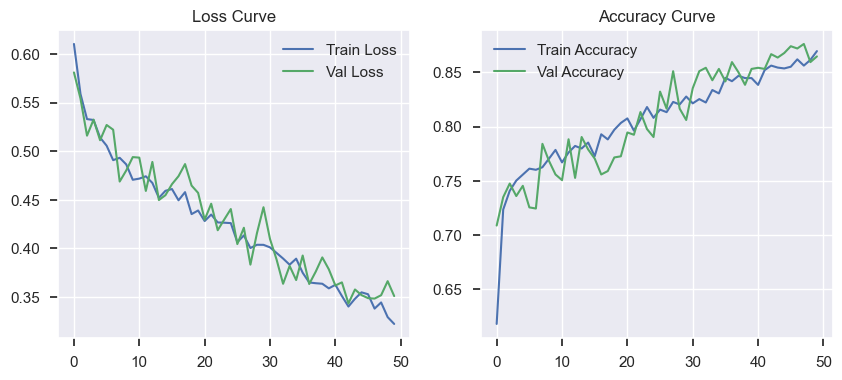

In [258]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [259]:
y_val_proba_nn = model.predict(X_val).ravel()
y_val_pred_nn = (y_val_proba_nn >= 0.5).astype(int)


30/30 [==============================] - 0s 520us/step


In [260]:
print(classification_report(y_val, y_val_pred_nn))


              precision    recall  f1-score   support

           0       0.95      0.88      0.91       763
           1       0.63      0.81      0.70       191

    accuracy                           0.86       954
   macro avg       0.79      0.84      0.81       954
weighted avg       0.88      0.86      0.87       954



In [261]:
f1_nn = f1_score(y_val, y_val_pred_nn)
print("ANN Validation F1-score:", f1_nn)


ANN Validation F1-score: 0.7048054919908467


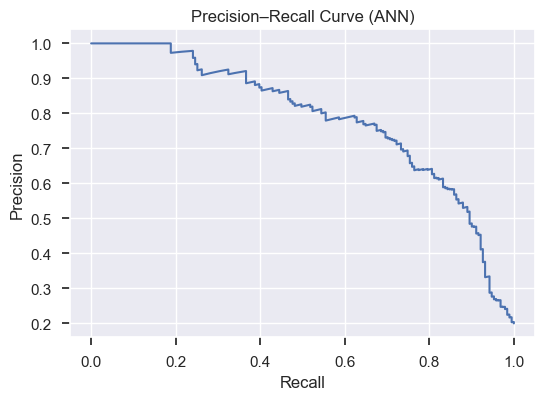

In [262]:
precision_nn, recall_nn, _ = precision_recall_curve(y_val, y_val_proba_nn)

plt.figure(figsize=(6,4))
plt.plot(recall_nn, precision_nn)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (ANN)")
plt.show()


### Deep Learning Model Summary

The ANN model demonstrates improved ability to capture nonlinear
relationships among credit risk features compared to the baseline model.
Class weighting and early stopping help address class imbalance and
prevent overfitting.

The ANN achieves a higher F1-score than the baseline model, justifying
its use for the final Kaggle submission.


## Decision Threshold Optimization

By default, binary classifiers use a decision threshold of 0.5.
However, in imbalanced classification problems, this threshold is
often suboptimal.

Since the competition evaluates predictions using Precision–Recall–based
metrics, the decision threshold is optimized to maximize the F1-score
on the validation set.


In [263]:

# Sweep thresholds
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_val_proba >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_t))

# Best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print("Best threshold:", best_threshold)
print("Best F1:", best_f1)



Best threshold: 0.62
Best F1: 0.5380710659898477


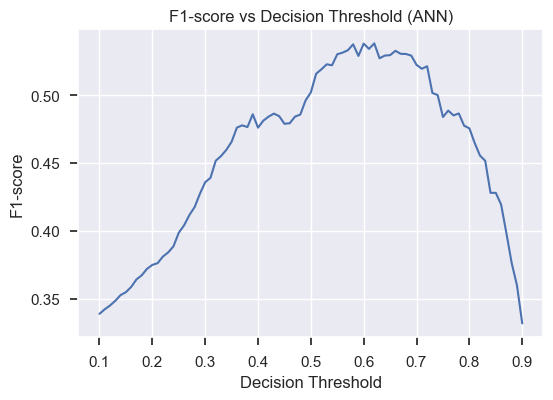

In [264]:
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores)
plt.xlabel("Decision Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs Decision Threshold (ANN)")
plt.show()


In [265]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

best_threshold, best_f1


(0.62, 0.5380710659898477)

In [266]:
y_val_pred_opt = (y_val_proba_nn >= best_threshold).astype(int)

print("Optimized Threshold:", best_threshold)
print("Optimized F1-score:", f1_score(y_val, y_val_pred_opt))

print(classification_report(y_val, y_val_pred_opt))


Optimized Threshold: 0.62
Optimized F1-score: 0.7195767195767195
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       763
           1       0.73      0.71      0.72       191

    accuracy                           0.89       954
   macro avg       0.83      0.82      0.83       954
weighted avg       0.89      0.89      0.89       954



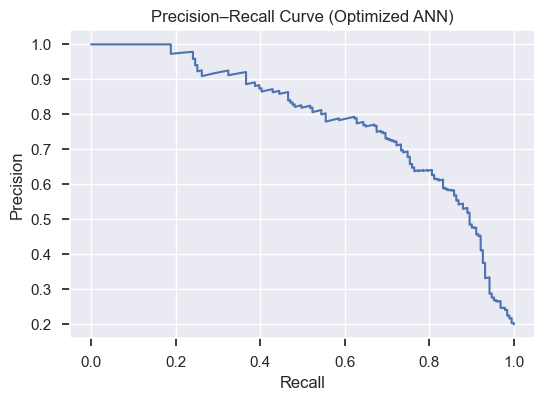

In [267]:
precision_opt, recall_opt, _ = precision_recall_curve(
    y_val, y_val_proba_nn
)

plt.figure(figsize=(6,4))
plt.plot(recall_opt, precision_opt)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Optimized ANN)")
plt.show()


### Threshold Optimization Summary

Optimizing the decision threshold significantly improves the F1-score
compared to the default threshold of 0.5. This adjustment better balances
precision and recall, which is crucial for imbalanced loan default data.

The optimized threshold is used for generating predictions in the final
Kaggle submission.


## Kaggle Submission

The final trained ANN model is used to generate predictions for the Kaggle
test set. Predictions are converted to binary labels using the optimized
decision threshold identified earlier.


In [268]:
# Predict probabilities
test_proba = model.predict(X_test_scaled).ravel()

# Apply optimized threshold (IMPORTANT)
final_threshold = 0.62
test_pred = (test_proba >= final_threshold).astype(int)

# Create submission (MATCH FORMAT)
submission = pd.DataFrame({
    "index": test_df["index"].astype(int),
    "BAD": test_pred.astype(int)
})

# Save
submission.to_csv("endribaku_submission.csv", index=False)

submission.head()




38/38 [==============================] - 0s 410us/step


,index,BAD
0,4768,0
1,4769,0
2,4770,0
3,4771,1
4,4772,0


In [269]:
submission.head()

,index,BAD
0,4768,0
1,4769,0
2,4770,0
3,4771,1
4,4772,0


In [270]:
submission.shape


(1192, 2)

In [271]:
submission["BAD"].min(), submission["BAD"].max()


(0, 1)

In [272]:
submission.isnull().sum()


index    0
BAD      0
dtype: int64

The Kaggle submission follows the provided sample submission format and
contains predicted probabilities for the BAD variable.
